In [14]:
#from f3dasm import ExperimentData
import numpy as np
from pathlib import Path
import pandas as pd
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures # For Polynomial basis functions
from sklearn.pipeline import make_pipeline # to link different objects
from matplotlib import cm # to change colors of surface plots
import matplotlib.pyplot as plt # import plotting tools to create figures
from sklearn.gaussian_process import GaussianProcessRegressor,GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, Matern, ExpSineSquared, ConstantKernel, WhiteKernel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import r2_score, mean_squared_error
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score


In [15]:
df_in_7d = pd.read_csv('data/supercompressible_7d_input.csv')
df_out_7d = pd.read_csv('data/supercompressible_7d_output.csv')

df_in_3d = pd.read_csv('data/supercompressible_3d_input.csv')
df_out_3d = pd.read_csv('data/supercompressible_3d_output.csv')

In [16]:
# define a function to do the preprocessing
# Input: input_raw_data, output_raw_data, problem_class
# input_raw_data: pandas dataframe for input
# output_raw_data: pandas dataframe for output
# problem_class: (booler) to describe this preprocess is for classification problem or not
#                this will lead to different scaler for Y data.
#
# Output: X_train_scale, X_test_scale, X_scale, Y_train_scale, Y_test_scale, Y_scale, scaler_x, scaler_y
# scaler_x: (scaler) used to do inverse_transfer after prediction
# scaler_y: (scaler) used to do inverse_transfer after prediction

def preprocess_3d(input_raw_data,output_raw_data,problem_class):
    if problem_class == False:
        raw_data = pd.concat([input_raw_data, output_raw_data], axis=1)

        # look at the # of missing points in the first ten columns
        raw_data_drop_nan = raw_data.dropna()

        X_3d = raw_data_drop_nan.loc[:, ['ratio_d','ratio_pitch','ratio_top_diameter'] ].values
        Y_3d = raw_data_drop_nan.loc[:, ['sigma_crit','energy'] ].values
        
        testset_ratio = 0.25
        SEED = 123
        X_train, X_test, Y_train, Y_test = train_test_split(X_3d,
                                            Y_3d, test_size=testset_ratio,
                                            random_state=SEED)

        scaler_x = StandardScaler()
        scaler_x.fit(X_train)
        X_train_scale=scaler_x.transform(X_train)
        X_test_scale=scaler_x.transform(X_test)
        X_scale=scaler_x.transform(X_3d)
        
        scaler_y = StandardScaler()
        scaler_y.fit(Y_train)
        Y_train_scale = scaler_y.transform(Y_train)
        Y_test_scale = scaler_y.transform(Y_test)
        Y_scale = scaler_y.transform(Y_3d)
    else:
        X_3d = input_raw_data.loc[:, ['ratio_d','ratio_pitch','ratio_top_diameter'] ].values
        Y_3d = output_raw_data.loc[:, 'coilable'].values
        
        testset_ratio = 0.25
        SEED = 123
        X_train, X_test, Y_train, Y_test = train_test_split(X_3d,
                                            Y_3d, test_size=testset_ratio,
                                            random_state=SEED)

        scaler_x = StandardScaler()
        scaler_x.fit(X_train)
        X_train_scale=scaler_x.transform(X_train)
        X_test_scale=scaler_x.transform(X_test)
        X_scale=scaler_x.transform(X_3d)

        scaler_y = FunctionTransformer() # FunctionTransformer without input will give a Identity scaler
        Y_train_scale = scaler_y.transform(Y_train)
        Y_test_scale = scaler_y.transform(Y_test)
        Y_scale = scaler_y.transform(Y_3d)

    return X_train_scale, X_test_scale, X_scale, Y_train_scale, Y_test_scale, Y_scale, scaler_x, scaler_y

In [17]:
X_train_scale_class, X_test_scale_class, X_scale_class, Y_train_scale_class, Y_test_scale_class, Y_scale_class, scaler_x_class, scaler_y_class = preprocess_3d(df_in_3d,df_out_3d,True)
X_train_scale_regression, X_test_scale_regression, X_scale_regression, Y_train_scale_regression, Y_test_scale_regression, Y_scale_regression, scaler_x_regression, scaler_y_regression = preprocess_3d(df_in_3d,df_out_3d,False)

In [18]:
# Define function to display classification when fixing "ratio_top_diameter"
# Input: X_data,Y_data,scaler_x, scaler_y,model,sample_index,grid_num=20
# X_data, Y_data, scaler_x: scaled data set for classification
# model: any model for predict classification problem
# sample_index: index of "ratio_top_diameter" pick the fixed ratio want to display
# grid_num: default value = 20, it determine how smooth we would like the contour figure to be, higher grid number lead to more time to compute (approximation 20 leads to 1 min) 
#
# Output: none but gives a figure
def classification_model_plot(X_data,Y_data,scaler_x, scaler_y,model,sample_index,grid_num=20):
    X_data_inverse = scaler_x.inverse_transform(X_data)

    x1, x2, x3 = X_data_inverse[:, 0], X_data_inverse[:, 1], X_data_inverse[:,2]

    x1_data_min, x1_data_max = x1.min(), x1.max() # define min & max of feature 0
    x2_data_min, x2_data_max = x2.min(), x2.max() # define min & max of feature 0
    #x3_data_min, x3_data_max = x3.min() - 0.005, x3.max() + 0.005 # define min & max of feature 0

    #grid_num = 20
    plot_step_1 = (x1_data_max-x1_data_min)/grid_num # defining the meshgrid step size
    plot_step_2 = (x1_data_max-x1_data_min)/grid_num
    plot_step = min((plot_step_1,plot_step_2))

    X1_data_grid, X2_data_grid = np.meshgrid(np.arange(x1_data_min, x1_data_max, plot_step),
                                            np.arange(x2_data_min, x2_data_max, plot_step))

    len(np.arange(x1_data_min, x1_data_max, plot_step))
    len(np.arange(x2_data_min, x2_data_max, plot_step))

    X1_data_space = np.zeros((len(np.arange(x1_data_min, x1_data_max, plot_step)),len(np.arange(x2_data_min, x2_data_max, plot_step)),len(x3)))
    X2_data_space = np.zeros((len(np.arange(x1_data_min, x1_data_max, plot_step)),len(np.arange(x2_data_min, x2_data_max, plot_step)),len(x3)))
    X3_data_space = np.zeros((len(np.arange(x1_data_min, x1_data_max, plot_step)),len(np.arange(x2_data_min, x2_data_max, plot_step)),len(x3)))

    for i in range(len(np.arange(x1_data_min, x1_data_max, plot_step))):
        for j in range(len(np.arange(x2_data_min, x2_data_max, plot_step))):
            for k in range(len(x3)):
                X1_data_space[i,j,k] = X1_data_grid[j,i]
                X2_data_space[i,j,k] = X2_data_grid[j,i]
                X3_data_space[i,j,k] = x3[k]

    y_class_SVM_pred_disp = model.predict(scaler_x.transform(np.c_[X1_data_space.ravel(), X2_data_space.ravel(), X3_data_space.ravel()]))
    y_class_SVM_pred_disp_grid = y_class_SVM_pred_disp.reshape(X1_data_space.shape)

    temp_sample = sample_index
    temp_disp = scaler_y.inverse_transform(y_class_SVM_pred_disp_grid[:,:,temp_sample])

    temp_x1 = X1_data_space[:,:,temp_sample]
    temp_x2 = X2_data_space[:,:,temp_sample]
    temp_x3 = x3[temp_sample]

    plot_colors = 'ryb' # defining the 3 colors for each category
    n_classes = 3
    target_names = ['Not coilable','coilable','coilable but yield']

    fig2, ax2 = plt.subplots(tight_layout=True)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)

    ax2.contourf(temp_x2, temp_x1, temp_disp, cmap=cm.RdYlBu, alpha=0.8)

    # Plot the training points
    ax2.scatter(X_data_inverse[temp_sample, 1], X_data_inverse[temp_sample, 0], c=plot_colors[Y_data[temp_sample]],
                    label=(Y_data[temp_sample],X_data_inverse[temp_sample, 2]), edgecolor='black', s=15)

    ax2.set_ylim(temp_x1.min(), temp_x1.max())
    ax2.set_xlim(temp_x2.min(), temp_x2.max())
    ax2.set_ylabel('ratio_d', fontsize=20)
    ax2.set_xlabel('ratio_pitch', fontsize=20)
    #ax2.set_xticks(())
    #ax2.set_yticks(())
    ax2.legend(loc='lower right', borderpad=0, handletextpad=0, fontsize=15)
    ax2.set_title('Support Vector Machine Classifier (SVC) with RBF kernel with ratio_top_diameter', fontsize=20)
    

In [19]:
# Define function to do the model training and predicting
# Input: X_train,X_test,X_data,Y_train,Y_test,Y_data,scaler_x, scaler_y,model
# X_train,X_test,X_data,Y_train,Y_test,Y_data,scaler_x, scaler_y,: scaled data set for classification
# model: any model for predict classification problem
#
# Output: ac_score,pr_score,re_score,f_one_score,con_matrix
# ac_score: accuracy_score with test sample
# pr_score: precision_score with test sample
# re_score: recall_score with test sample
# f_one_score: f1_score with test sample
# con_matrix: confusion_matrix with test sample 

def classification_model_train_and_predict(X_train,X_test,X_data,Y_train,Y_test,Y_data,scaler_x, scaler_y,model):
    model.fit(X_train,Y_train)
    Y_predict_for_test = model.predict(X_test)
    ac_score = accuracy_score(Y_test,Y_predict_for_test)
    pr_score = precision_score(Y_test,Y_predict_for_test,average='micro')
    re_score = recall_score(Y_test,Y_predict_for_test,average='micro')
    f_one_score = f1_score(Y_test,Y_predict_for_test,average='micro')
    con_matrix = confusion_matrix(Y_test,Y_predict_for_test)

    #classification_model_plot(X_data,Y_data,scaler_x, scaler_y,model,249,20)

    return ac_score,pr_score,re_score,f_one_score,con_matrix

In [20]:
# Define SVM model
svm_model = svm.SVC(kernel='rbf')

# Set up the parameter grid
parameter_grid = {'C': [0.75, 0.8, 0.85, 0.9, 0.95, 1, 1.05, 1.1, 1.15, 1.2, 1.25], 
                  'gamma': [0.75, 0.8, 0.85, 0.9, 0.95, 1, 1.05, 1.1, 1.15, 1.2, 1.25]}

# Configure GridSearchCV
grid_search = GridSearchCV(svm_model, parameter_grid, cv=5)

# Fit the grid search model
grid_search.fit(X_train_scale_class, Y_train_scale_class)

# Find the best parameters and score
best_parameters = grid_search.best_params_
best_score = grid_search.best_score_

# Create and fit the optimal model
optimal_model = svm.SVC(kernel='rbf', C=best_parameters['C'], gamma=best_parameters['gamma'])

ac_score,pr_score,re_score,f_one_score,con_matrix = classification_model_train_and_predict(X_train_scale_class, X_test_scale_class, X_scale_class, Y_train_scale_class, Y_test_scale_class, Y_scale_class,scaler_x_class, scaler_y_class,optimal_model)
print(ac_score)
print(pr_score)
print(re_score)
print(f_one_score)
print(con_matrix)

0.816
0.816
0.816
0.816
[[ 69   6   3]
 [  6  32  15]
 [  6  10 103]]


In [21]:
# Define function to display classification when fixing "ratio_top_diameter"
# Input: X_data,Y_data,scaler_x, scaler_y,model,sample_index,grid_num=20
# X_data, Y_data, scaler_x: scaled data set for classification
# model: any model for predict classification problem
# sample_index: index of "ratio_top_diameter" pick the fixed ratio want to display
# grid_num: default value = 20, it determine how smooth we would like the contour figure to be, higher grid number lead to more time to compute (approximation 20 leads to 1 min) 
#
# Output: none but gives a figure
def regression_model_plot(X_data,Y_data,scaler_x, scaler_y,model,sample_index,grid_num=20,problem_sigma = True):
    X_data_inverse = scaler_x.inverse_transform(X_data)
    Y_data_inverse = scaler_y.inverse_transform(Y_data)
    x1, x2, x3 = X_data_inverse[:, 0], X_data_inverse[:, 1], X_data_inverse[:,2]

    x1_data_min, x1_data_max = x1.min(), x1.max() # define min & max of feature 0
    x2_data_min, x2_data_max = x2.min(), x2.max() # define min & max of feature 0
    #x3_data_min, x3_data_max = x3.min() - 0.005, x3.max() + 0.005 # define min & max of feature 0

    #grid_num = 20
    plot_step_1 = (x1_data_max-x1_data_min)/grid_num # defining the meshgrid step size
    plot_step_2 = (x1_data_max-x1_data_min)/grid_num
    plot_step = min((plot_step_1,plot_step_2))

    X1_data_grid, X2_data_grid = np.meshgrid(np.arange(x1_data_min, x1_data_max, plot_step),
                                            np.arange(x2_data_min, x2_data_max, plot_step))

    len(np.arange(x1_data_min, x1_data_max, plot_step))
    len(np.arange(x2_data_min, x2_data_max, plot_step))

    X1_data_space = np.zeros((len(np.arange(x1_data_min, x1_data_max, plot_step)),len(np.arange(x2_data_min, x2_data_max, plot_step)),len(x3)))
    X2_data_space = np.zeros((len(np.arange(x1_data_min, x1_data_max, plot_step)),len(np.arange(x2_data_min, x2_data_max, plot_step)),len(x3)))
    X3_data_space = np.zeros((len(np.arange(x1_data_min, x1_data_max, plot_step)),len(np.arange(x2_data_min, x2_data_max, plot_step)),len(x3)))

    for i in range(len(np.arange(x1_data_min, x1_data_max, plot_step))):
        for j in range(len(np.arange(x2_data_min, x2_data_max, plot_step))):
            for k in range(len(x3)):
                X1_data_space[i,j,k] = X1_data_grid[j,i]
                X2_data_space[i,j,k] = X2_data_grid[j,i]
                X3_data_space[i,j,k] = x3[k]

    if problem_sigma == True:
        y_class_SVM_pred_disp = model.predict(scaler_x.transform(np.c_[X1_data_space.ravel(), X2_data_space.ravel(), X3_data_space.ravel()]))
        y_class_SVM_pred_disp_inverse = scaler_y.inverse_transform(y_class_SVM_pred_disp)

        y_class_SVM_pred_disp_grid = y_class_SVM_pred_disp_inverse[:,0].reshape(X1_data_space.shape)

        temp_sample = sample_index
        temp_disp = y_class_SVM_pred_disp_grid[:,:,temp_sample]

        temp_x1 = X1_data_space[:,:,temp_sample]
        temp_x2 = X2_data_space[:,:,temp_sample]
        temp_x3 = x3[temp_sample]

        #plot_colors = 'ryb' # defining the 3 colors for each category
        #n_classes = 3
        #target_names = ['Not coilable','coilable','coilable but yield']

        fig2, ax3 = plt.subplots(tight_layout=True)
        plt.subplots_adjust(wspace=0.4, hspace=0.4)

        
        ax3.contourf(temp_x2, temp_x1, temp_disp, cmap=cm.RdYlBu, alpha=0.8)
        # Plot the training points
        ax3.scatter(X_data_inverse[temp_sample, 1], X_data_inverse[temp_sample, 0], c=Y_data_inverse[temp_sample,0],
                        label=(Y_data[temp_sample,0],X_data_inverse[temp_sample, 2]), edgecolor='black', s=15)
    else:
        y_class_SVM_pred_disp = model.predict(scaler_x.transform(np.c_[X1_data_space.ravel(), X2_data_space.ravel(), X3_data_space.ravel()]))
        y_class_SVM_pred_disp_inverse = scaler_y.inverse_transform(y_class_SVM_pred_disp)

        y_class_SVM_pred_disp_grid = y_class_SVM_pred_disp_inverse[:,1].reshape(X1_data_space.shape)

        temp_sample = sample_index
        temp_disp = y_class_SVM_pred_disp_grid[:,:,temp_sample]

        temp_x1 = X1_data_space[:,:,temp_sample]
        temp_x2 = X2_data_space[:,:,temp_sample]
        temp_x3 = x3[temp_sample]

        fig2, ax3 = plt.subplots(tight_layout=True)
        plt.subplots_adjust(wspace=0.4, hspace=0.4)

        
        ax3.contourf(temp_x2, temp_x1, temp_disp, cmap=cm.RdYlBu, alpha=0.8)
        # Plot the training points
        ax3.scatter(X_data_inverse[temp_sample, 1], X_data_inverse[temp_sample, 0], c=Y_data_inverse[temp_sample,1],
                        label=(Y_data[temp_sample,1],X_data_inverse[temp_sample, 2]), edgecolor='black', s=15)

    ax3.set_ylim(temp_x1.min(), temp_x1.max())
    ax3.set_xlim(temp_x2.min(), temp_x2.max())
    ax3.set_ylabel('ratio_d', fontsize=20)
    ax3.set_xlabel('ratio_pitch', fontsize=20)
    #ax2.set_xticks(())
    #ax2.set_yticks(())
    ax3.legend(loc='lower right', borderpad=0, handletextpad=0, fontsize=15)
    ax3.set_title('Support Vector Machine Classifier (SVC) with RBF kernel with ratio_top_diameter', fontsize=20)
    fig2.colorbar(cm.ScalarMappable(norm=None, cmap=cm.RdYlBu), ax=ax3)
    

In [22]:
def regression_model_train_and_predict(X_train,X_test,X_data,Y_train,Y_test,Y_data,scaler_x,scaler_y,model):
    model.fit(X_train,Y_train)
    Y_predict_for_test = model.predict(X_test)
    r2 = r2_score(Y_test,Y_predict_for_test)
    mse = mean_squared_error(Y_test,Y_predict_for_test)

    #regression_model_plot(X_data,Y_data,scaler_x,scaler_y,model,5,10,True)
    # this function is not finished, and we can just check r2 score and mse for comparing our results

    return r2, mse

In [23]:
kernel = Matern(length_scale=1.0, length_scale_bounds=(1e-2, 1e2),nu=2.5)
gpr_model = GaussianProcessRegressor(kernel=kernel, alpha=1e-3, optimizer='fmin_l_bfgs_b', n_restarts_optimizer=20)

r2, mse = regression_model_train_and_predict(X_train_scale_regression, X_test_scale_regression, X_scale_regression, Y_train_scale_regression, Y_test_scale_regression, Y_scale_regression,scaler_x_regression, scaler_y_regression,gpr_model)

print(r2)
print(mse)

0.999327804769986
0.0006239489578574316


## search for the optimum points

In [134]:
def find_best_point_in_dataset(X_data,Y_data,scaler_x, scaler_y,class_model):
    y_class_pred = class_model.predict(X_data)
    coilable_points_x = []
    coilable_points_y = []

    X_data_inverse = scaler_x.inverse_transform(X_data)
    Y_data_inverse = scaler_y.inverse_transform(Y_data)
    for class_pred_index in range(len(y_class_pred)):
        if y_class_pred[class_pred_index] == 1:
            coilable_points_x.append(X_data_inverse[class_pred_index,:])
            coilable_points_y.append(Y_data_inverse[class_pred_index,:])
            
    best_simga = coilable_points_y[0][0]
    best_sigma_index = 0
    best_energy = coilable_points_y[0][1]
    best_energy_index = 0

    for index in range(len(coilable_points_x)):
        if coilable_points_y[index][0] > best_simga:
            best_sigma = coilable_points_y[index][0]
            best_sigma_index = index
        if coilable_points_y[index][1] > best_energy:
            best_energy = coilable_points_y[index][1]
            best_energy_index = index

    best_sigma_input = coilable_points_x[best_sigma_index]
    best_energy_input = coilable_points_x[best_energy_index]

    return best_sigma,best_energy,best_sigma_input,best_energy_input
    


In [135]:
best_sigma,best_energy,best_sigma_input,best_energy_input = find_best_point_in_dataset(X_scale_regression,Y_scale_regression,scaler_x_regression,scaler_y_regression,optimal_model)
print(best_sigma)
print(best_energy)
print(best_sigma_input)
print(best_energy_input)

0.0044113421210632
4.623396082220791
[0.00622363 0.60522461 0.36484375]
[0.03863477 0.25244141 0.7265625 ]


## different optimization algorithms

In [133]:
svc = optimal_model  # Your trained SVC model
gpr = gpr_model 

test = scaler_x_class.transform([[0.03863477, 0.25244141, 0.7265625]])
svc.predict(test)

array([2])

In [131]:
import numpy as np
from scipy.optimize import minimize 
#import gpyopt.methods

# Assuming you have trained your SVC and GPR models already
svc = optimal_model  # Your trained SVC model
gpr = gpr_model  # Your trained GPR model with Matern kernel

global sigma_converge_space
sigma_converge_space = []
global energy_converge_space
energy_converge_space = []


def objective_function(x, target_output):
    # Ensure that the input is classified as '1' by the SVC
    x_scale_class = scaler_x_class.transform([x])
    x_scale = scaler_x_regression.transform([x])

    if svc.predict(x_scale_class) != 1:
        return float('inf')
    
    # Predict with GPR and get the desired output
    gpr_result = gpr.predict(x_scale, return_std=False)
    result = scaler_y_regression.inverse_transform(gpr_result)
    sigma = result[0][0]
    energy = result[0][1]
    if target_output == 'sigma':
        sigma_converge_space.append(sigma)
        return -sigma  # Negative because we are using a minimization function
    elif target_output == 'energy':
        energy_converge_space.append(energy)
        return -energy

# Initial guess for the optimizer
initial_guess_sigma = np.array([0.00622363,0.60522461,0.36484375])  # Fill with appropriate starting point
initial_guess_energy = np.array([0.03863477,0.25244141,0.7265625])  # Fill with appropriate starting point

# Optimize for sigma
#result_sigma = minimize(objective_function, initial_guess_sigma, args=('sigma',), method='Nelder-Mead',bounds=[(0,100),(0,100),(0,100)])
result_sigma = minimize(objective_function, initial_guess_sigma, args=('sigma',), method='Nelder-Mead',options={'disp': True} )
optimal_sigma = -result_sigma.fun  # Negate because we minimized the negative sigma
optimal_sigma_input = result_sigma.x

# Optimize for energy
result_energy = minimize(objective_function, initial_guess_energy, args=('energy',), method='Nelder-Mead',options={'disp': True} )
optimal_energy = -result_energy.fun  # Negate because we minimized the negative energy
optimal_energy_input = result_energy.x


print("Optimal Sigma:", optimal_sigma)
print("Optimal Sigma inputs:", optimal_sigma_input)

print("Optimal Energy:", optimal_energy)
print("Optimal Energy inputs:", optimal_energy_input)



Optimization terminated successfully.
         Current function value: -1.159804
         Iterations: 156
         Function evaluations: 294
Optimal Sigma: 1.1598037507105836
Optimal Sigma inputs: [-0.00618821  1.29635916  0.31160178]
Optimal Energy: -inf
Optimal Energy inputs: [0.03863477 0.25244141 0.7265625 ]


/Users/chenjie/mambaforge/envs/3dasm/lib/python3.10/site-packages/scipy/optimize/_optimize.py:917: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):
/Users/chenjie/mambaforge/envs/3dasm/lib/python3.10/site-packages/scipy/optimize/_optimize.py:917: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):
/Users/chenjie/mambaforge/envs/3dasm/lib/python3.10/site-packages/scipy/optimize/_optimize.py:917: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):
/Users/chenjie/mambaforge/envs/3dasm/lib/python3.10/site-packages/scipy/optimize/_optimize.py:917: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):
/Users/chenjie/mambaforge/envs/3dasm/lib/python3.10/site-packages/scipy/optimize/_optimize.py:917: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fat

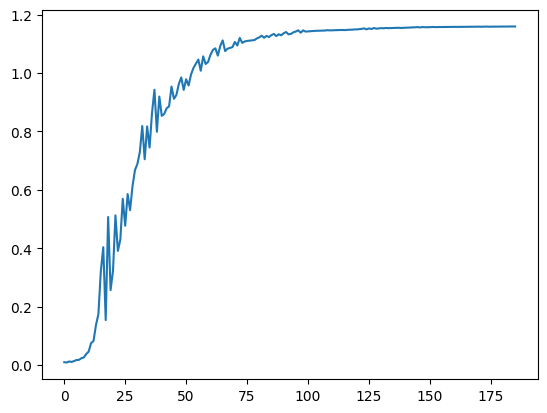

In [124]:
plt.plot(sigma_converge_space)

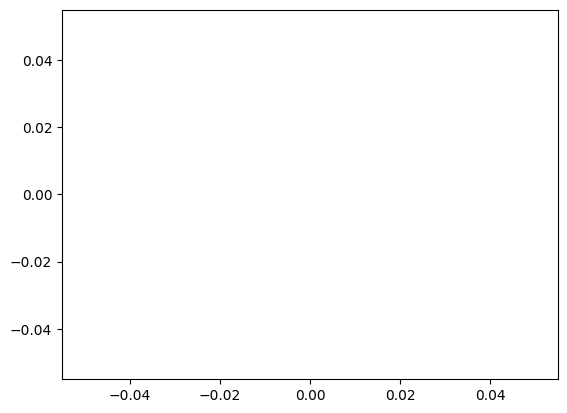

In [125]:
plt.plot(energy_converge_space)

In [126]:
import numpy as np
from scipy.optimize import minimize 
#import gpyopt.methods

# Assuming you have trained your SVC and GPR models already
svc = optimal_model  # Your trained SVC model
gpr = gpr_model  # Your trained GPR model with Matern kernel

global sigma_converge_space
sigma_converge_space = []
global energy_converge_space
energy_converge_space = []


def objective_function(x, target_output):
    # Ensure that the input is classified as '1' by the SVC
    x_scale = scaler_x_regression.transform([x])

    if svc.predict(x_scale) != 1:
        return float('inf')
    
    # Predict with GPR and get the desired output
    gpr_result = gpr.predict(x_scale, return_std=False)
    result = scaler_y_regression.inverse_transform(gpr_result)
    sigma = result[0][0]
    energy = result[0][1]
    if target_output == 'sigma':
        sigma_converge_space.append(sigma)
        return -sigma  # Negative because we are using a minimization function
    elif target_output == 'energy':
        energy_converge_space.append(energy)
        return -energy

# Initial guess for the optimizer
initial_guess_sigma = np.array([0.00622363,0.60522461,0.36484375])  # Fill with appropriate starting point
initial_guess_energy = np.array([0.03863477,0.25244141,0.7265625])  # Fill with appropriate starting point

# Optimize for sigma
#result_sigma = minimize(objective_function, initial_guess_sigma, args=('sigma',), method='Nelder-Mead',bounds=[(0,100),(0,100),(0,100)])
result_sigma = minimize(objective_function, initial_guess_sigma, args=('sigma',), method='L-BFGS-B',options={'disp': True} )
optimal_sigma = -result_sigma.fun  # Negate because we minimized the negative sigma
optimal_sigma_input = result_sigma.x

# Optimize for energy
result_energy = minimize(objective_function, initial_guess_energy, args=('energy',), method='L-BFGS-B',options={'disp': True} )
optimal_energy = -result_energy.fun  # Negate because we minimized the negative energy
optimal_energy_input = result_energy.x


print("Optimal Sigma:", optimal_sigma)
print("Optimal Sigma inputs:", optimal_sigma_input)

print("Optimal Energy:", optimal_energy)
print("Optimal Energy inputs:", optimal_energy_input)



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.54208D-03    |proj g|=  3.50453D+00

At iterate    1    f= -9.54208D-03    |proj g|=  3.50453D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      1      3      1     0     0   3.505D+00  -9.542D-03
  F =  -9.5420828729437801E-003

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 v

 This problem is unconstrained.
/Users/chenjie/mambaforge/envs/3dasm/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/chenjie/mambaforge/envs/3dasm/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/chenjie/mambaforge/envs/3dasm/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
 This problem is unconstrained.
/Users/chenjie/mambaforge/envs/3dasm/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/chenjie/mambaforge/envs/3dasm/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/chenjie/mambaforge/envs/3dasm/lib/python3.10/site-packages/scipy/optimize/

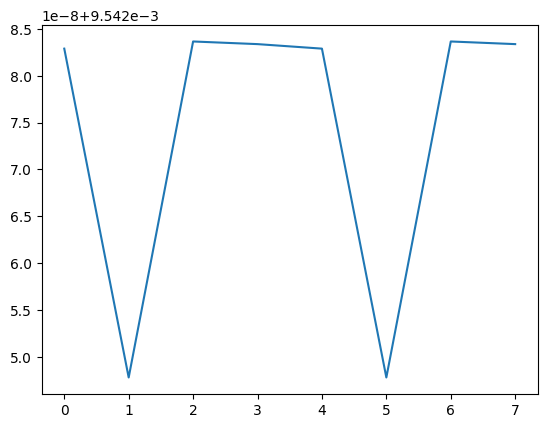

In [127]:
plt.plot(sigma_converge_space)

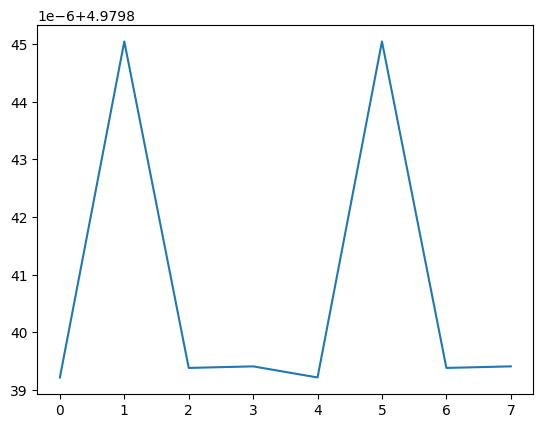

In [128]:
plt.plot(energy_converge_space)

In [129]:
import numpy as np
from scipy.optimize import minimize 
#import gpyopt.methods

# Assuming you have trained your SVC and GPR models already
svc = optimal_model  # Your trained SVC model
gpr = gpr_model  # Your trained GPR model with Matern kernel

global sigma_converge_space
sigma_converge_space = []
global energy_converge_space
energy_converge_space = []


def objective_function(x, target_output):
    # Ensure that the input is classified as '1' by the SVC
    x_scale = scaler_x_regression.transform([x])

    if svc.predict(x_scale) != 1:
        return float('inf')
    
    # Predict with GPR and get the desired output
    gpr_result = gpr.predict(x_scale, return_std=False)
    result = scaler_y_regression.inverse_transform(gpr_result)
    sigma = result[0][0]
    energy = result[0][1]
    if target_output == 'sigma':
        sigma_converge_space.append(sigma)
        return -sigma  # Negative because we are using a minimization function
    elif target_output == 'energy':
        energy_converge_space.append(energy)
        return -energy

# Initial guess for the optimizer
initial_guess_sigma = np.array([0.00622363,0.60522461,0.36484375])  # Fill with appropriate starting point
initial_guess_energy = np.array([0.03863477,0.25244141,0.7265625])  # Fill with appropriate starting point

# Optimize for sigma
#result_sigma = minimize(objective_function, initial_guess_sigma, args=('sigma',), method='Nelder-Mead',bounds=[(0,100),(0,100),(0,100)])
result_sigma = minimize(objective_function, initial_guess_sigma, args=('sigma',), method='CG',options={'disp': True} )
optimal_sigma = -result_sigma.fun  # Negate because we minimized the negative sigma
optimal_sigma_input = result_sigma.x

# Optimize for energy
result_energy = minimize(objective_function, initial_guess_energy, args=('energy',), method='CG',options={'disp': True} )
optimal_energy = -result_energy.fun  # Negate because we minimized the negative energy
optimal_energy_input = result_energy.x


print("Optimal Sigma:", optimal_sigma)
print("Optimal Sigma inputs:", optimal_sigma_input)

print("Optimal Energy:", optimal_energy)
print("Optimal Energy inputs:", optimal_energy_input)



         Current function value: -0.009542
         Iterations: 0
         Function evaluations: 33
         Gradient evaluations: 6
         Current function value: -4.979839
         Iterations: 0
         Function evaluations: 33
         Gradient evaluations: 6
Optimal Sigma: 0.00954208287294378
Optimal Sigma inputs: [0.00622363 0.60522461 0.36484375]
Optimal Energy: 4.979839215786608
Optimal Energy inputs: [0.03863477 0.25244141 0.7265625 ]


/Users/chenjie/mambaforge/envs/3dasm/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/chenjie/mambaforge/envs/3dasm/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/chenjie/mambaforge/envs/3dasm/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/chenjie/mambaforge/envs/3dasm/lib/python3.10/site-packages/scipy/optimize/_minimize.py:703: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_cg(fun, x0, args, jac, callback, **options)
/Users/chenjie/mambaforge/envs/3dasm/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/chenjie/mambaforge/envs/3dasm/lib/python3.10/site-packages/scipy/opti

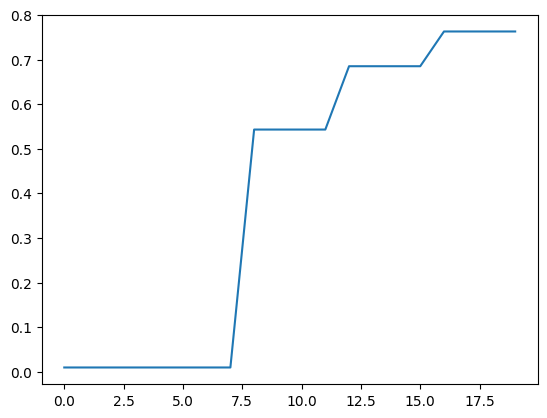

In [130]:
plt.plot(sigma_converge_space)

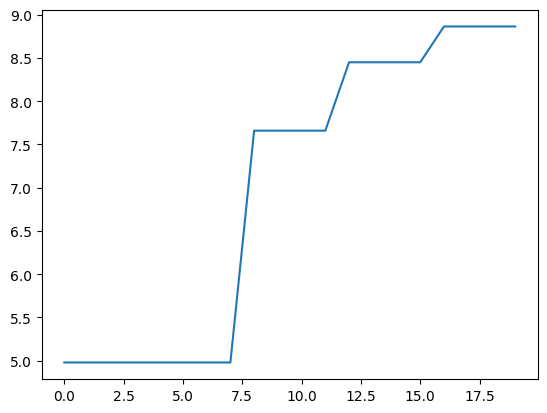

In [121]:
plt.plot(energy_converge_space)